# Titanic - Experiment 11
### 1. Exploratory Data Analysis 
### 2. Feature Engineering and Data Cleaning
### 3. Modeling

In [1]:
# Import libraries
import os
import sys
import warnings

import scipy
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from Titanic.Code.DataPrep.titanic import Titanic
from Titanic.Code.DataPrep.helpers import score_impute_strategies

# Notebook settings
warnings.filterwarnings('ignore')
np.random.seed(17)
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('fivethirtyeight')
%matplotlib inline

## 1. Exploratory Data Analysis

In [2]:
# Make training Titanic object
titanic = Titanic(name='train')

# Read training data
titanic.get_data()

In [3]:
titanic.data.shape

(891, 11)

In [4]:
titanic.data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
titanic.dtypes_

{'PassengerId': numpy.int32,
 'Survived': numpy.int32,
 'Pclass': numpy.int32,
 'Name': str,
 'Sex': CategoricalDtype(categories=['male', 'female'], ordered=None),
 'Age': numpy.float64,
 'SibSp': numpy.int32,
 'Parch': numpy.int32,
 'Ticket': str,
 'Fare': numpy.float64,
 'Cabin': str,
 'Embarked': CategoricalDtype(categories=['C', 'Q', 'S'], ordered=None)}

In [6]:
titanic.data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


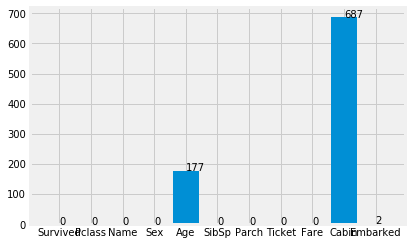

In [7]:
titanic.plot_missing_data()

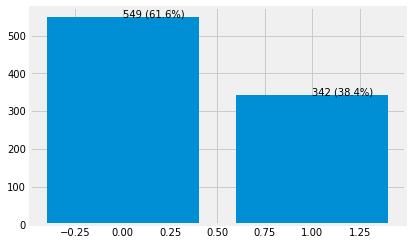

In [8]:
titanic.plot_value_counts(column='Survived')

We can assume, an average of 38% of passengers aboard the Titanic survived - this will be the baseline accuracy threshold.

## 2. Feature Engineering and Data Cleaning

To keep it simple, we're going to drop the 'Cabin' column and any records with missing values in 'Age' and 'Embarked'. In addition, we're going to drop the 'Ticket' column due to the complicated alphanumeric schema.

In [9]:
titanic.clean_data()

In [10]:
titanic.data = titanic.data.dropna()

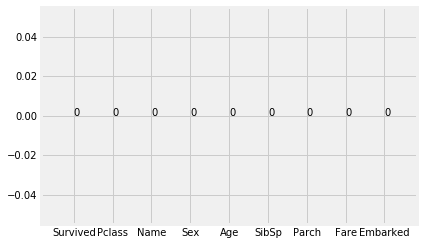

In [11]:
titanic.plot_missing_data()

Lastly, we're going to drop the 'Name' column. Maybe we'll re-incorporate it later.

In [12]:
titanic.drop_column('Name')

In [13]:
titanic.data.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,712.000000,712.000000,712,712.000000,712.000000,712.000000,712.000000,712
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3
top,NaN,NaN,male,NaN,NaN,NaN,NaN,S
freq,NaN,NaN,453,NaN,NaN,NaN,NaN,554
mean,0.404494,2.240169,NaN,29.642093,0.514045,0.432584,34.567251,NaN
std,0.491139,0.836854,NaN,14.492933,0.930692,0.854181,52.938648,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN
25%,0.000000,1.000000,NaN,20.000000,0.000000,0.000000,8.050000,NaN
50%,0.000000,2.000000,NaN,28.000000,0.000000,0.000000,15.645850,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,1.000000,33.000000,NaN


Before modeling, we should encode our labeled features: 'Sex' and 'Embarked'.

In [14]:
titanic.encode_labels('Sex')
titanic.encode_labels('Embarked')
titanic.data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_Code,Embarked_Code
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,1,2
2,1,1,female,38.0,1,0,71.2833,C,0,0
3,1,3,female,26.0,0,0,7.9250,S,0,2
4,1,1,female,35.0,1,0,53.1000,S,0,2
5,0,3,male,35.0,0,0,8.0500,S,1,2


Separate X and y; split data into train and test sets.

In [15]:
X = titanic.data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_Code', 'Embarked_Code']]
y = titanic.data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y)

## 3. Modeling

In [16]:
clf_names = [
    'logistic_regression',
    'decision_tree',
    'extra_trees',
    'random_forest',
    'k_neighbors'
]

clf_est = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    ExtraTreesClassifier(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]

clf_dict = dict(zip(clf_names, clf_est))

In [17]:
df_results = pd.DataFrame(
    columns=[
        'Estimator',
        'Score'
    ]
)

for k, v in clf_dict.items():
    dict_result = dict()
    v = v.fit(X_train, y_train)
    dict_result['Estimator'] = k
    dict_result['Score'] = v.score(X_test, y_test)
    df_results = df_results.append(dict_result, ignore_index=True)

df_results = df_results.sort_values('Score', ascending=False)
display(df_results)

,Estimator,Score
0,logistic_regression,0.814607
2,extra_trees,0.792135
3,random_forest,0.780899
1,decision_tree,0.741573
4,k_neighbors,0.691011


Looks like the highest scoring out-of-the-box classifier was a Logistic Regression model.